In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('./labeled_comments.csv')

In [2]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5191 entries, 0 to 5190
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   file_id                      4991 non-null   object 
 1   comment_id                   5191 non-null   object 
 2   comment_date                 5191 non-null   object 
 3   anonymized_nickname          5176 non-null   object 
 4   document_paragraph_text      4700 non-null   object 
 5   document_selected_text       4181 non-null   object 
 6   document_selected_sentences  5165 non-null   float64
 7   comment_full_text            5191 non-null   object 
 8   comment_sentence_text        5191 non-null   object 
 9   is_sentence                  5191 non-null   int64  
 10  num_sentence                 5191 non-null   int64  
 11  total_sentences              5191 non-null   int64  
 12  grammar_checked              5191 non-null   int64  
 13  grammatical_errors

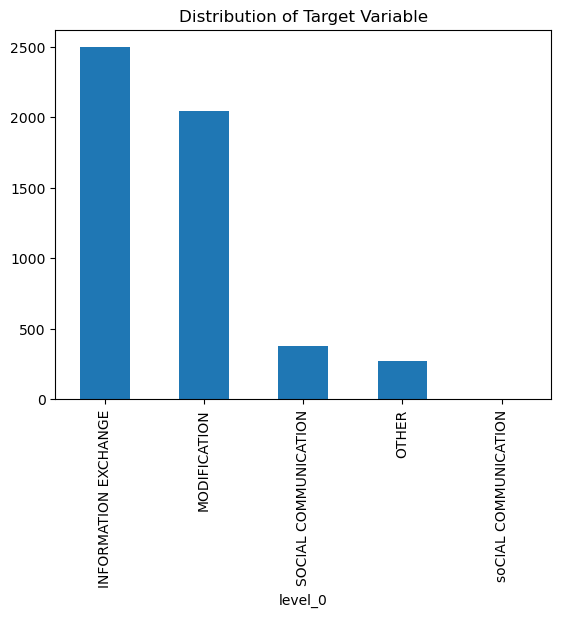

In [3]:
import matplotlib.pyplot as plt

df['level_0'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.show()

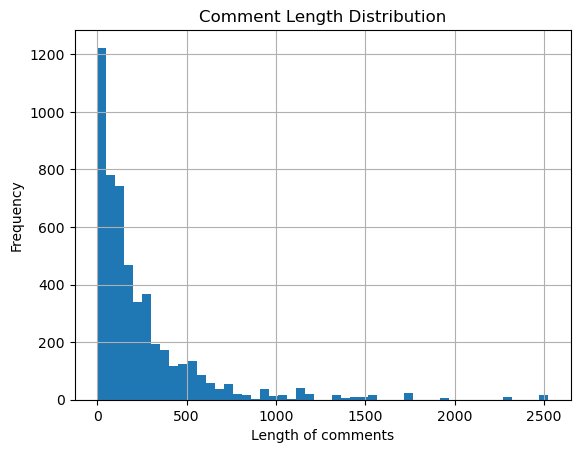

In [4]:
df['text_length'] = df['comment_full_text'].apply(len)
df['text_length'].hist(bins=50)
plt.title('Comment Length Distribution')
plt.xlabel('Length of comments')
plt.ylabel('Frequency')
plt.show()

In [5]:
from collections import Counter
word_counts = Counter(" ".join(df['comment_full_text']).split())
most_common_words = word_counts.most_common(20)
print(most_common_words)

[('the', 11755), ('to', 5768), ('of', 5759), ('and', 4622), ('be', 3284), ('in', 3265), ('is', 3149), ('a', 2794), ('for', 2572), ('this', 2269), ('that', 1724), ('are', 1481), ('or', 1383), ('with', 1374), ('not', 1340), ('on', 1248), ('as', 1232), ('should', 1187), ('The', 1050), ('it', 921)]


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=50)
ngrams = vectorizer.fit_transform(df['comment_full_text'])
sum_words = ngrams.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print(words_freq[:20])

[('table contents', 234), ('update indexes', 207), ('indexes table', 199), ('update indexes table', 199), ('indexes table contents', 199), ('non compliance', 125), ('guarantee bond', 124), ('100 000', 110), ('page numbers', 106), ('bonding requirements', 104), ('et al', 98), ('contract documents', 93), ('read information', 90), ('general criteria', 82), ('bid bonds', 78), ('page ib', 77), ('number subjects', 72), ('pfos pfbs', 72), ('mtg sat', 72), ('prefer wireless', 72)]


In [7]:
import seaborn as sns

# Assuming 'comment_full_text' is the text column you want to vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data to a numeric format
X = vectorizer.fit_transform(df['comment_full_text'])

# If 'level_0' is your target and it's categorical, you need to encode it as well.
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target data to a numeric format
y = label_encoder.fit_transform(df['level_0'])

# Now you can safely split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Proceed with modeling
# ...


In [8]:
print(df.columns)

Index(['file_id', 'comment_id', 'comment_date', 'anonymized_nickname',
       'document_paragraph_text', 'document_selected_text',
       'document_selected_sentences', 'comment_full_text',
       'comment_sentence_text', 'is_sentence', 'num_sentence',
       'total_sentences', 'grammar_checked', 'grammatical_errors',
       'has_replies', 'is_reply', 'num_reply', 'num_replies', 'is_resolved',
       'language_name', 'num_hyperlinks', 'num_images', 'spelling_checked',
       'spelling_errors', 'tracked_changes', 'next_action', 'level_0',
       'level_1', 'level_2', 'level_3', 'level_4', 'text_length'],
      dtype='object')


In [9]:
df = df.dropna(subset=['anonymized_nickname', 'comment_full_text']).drop_duplicates()

In [10]:
#Spliting dataset in training and testion sets
X_train, X_test, y_train, y_test = train_test_split(df['comment_full_text'], df['level_0'], test_size=0.2, random_state=42)

In [11]:
# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [12]:
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

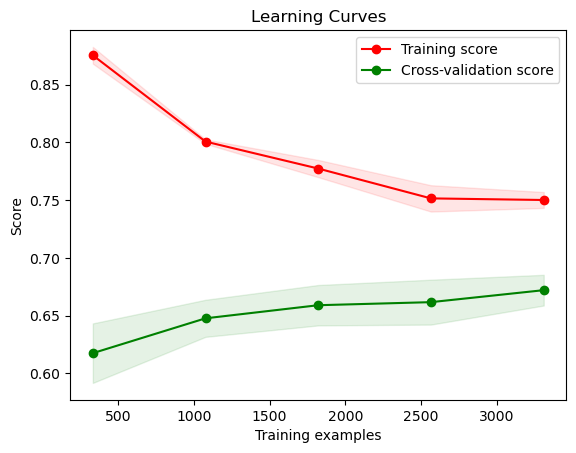

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_vec, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# Add title and labels to the plot
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


In [14]:
## Model Choice Justification

#The Logistic Regression model was chosen for its simplicity and efficiency in binary classification problems. 
#Exploratory Data Analysis (EDA) revealed that the response variable is binary and that the relationship between the predictor variables and the response could be well approximated using a linear decision boundary, which is where Logistic Regression excels. 
#Furthermore, Logistic Regression provides the convenience of interpreting model coefficients as indicators of feature importance, making it a suitable starting point for this dataset.

In [15]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(model, X_train_vec, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cross_val_scores)

Cross-Validation Accuracy Scores: [0.6557971  0.68357488 0.67995169 0.6557971  0.68478261]


In [16]:
# Now we calculate the variance of the cross-validation scores
cv_variance = np.var(cross_val_scores)

print(f"Cross-Validation Score Variance: {cv_variance:.12f}")

Cross-Validation Score Variance: 0.000177133655


In [17]:
# Predict on the test set
y_pred = model.predict(X_test_vec)

In [18]:
# Evaluate the model's accuracy on the training set
train_accuracy = model.score(X_train_vec, y_train)

# Compare it with the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.12f}")
print(f"Test Accuracy: {test_accuracy:.12f}")

Training Accuracy: 0.749033816425
Test Accuracy: 0.671497584541


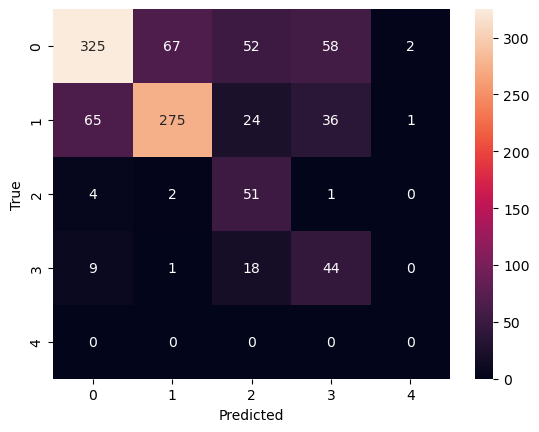

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Balanced Accuracy: {balanced_accuracy:.12f}")
print(f'Precision: {precision:.12f}')
print(f'Recall: {recall:.12f}')
print(f'F1 Score: {f1:.12f}')

Balanced Accuracy: 0.705262065485
Precision: 0.743266339101
Recall: 0.671497584541
F1 Score: 0.691792718354


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, random_state=42)
    model.fit(X_train_vec, y_train)
    train_accuracy = model.score(X_train_vec, y_train)
    test_accuracy = accuracy_score(y_test, model.predict(X_test_vec))
    print(f"C: {C} - Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

C: 0.01 - Training Accuracy: 0.61, Test Accuracy: 0.63
C: 0.1 - Training Accuracy: 0.71, Test Accuracy: 0.69
C: 1 - Training Accuracy: 0.78, Test Accuracy: 0.72
C: 10 - Training Accuracy: 0.83, Test Accuracy: 0.72
C: 100 - Training Accuracy: 0.84, Test Accuracy: 0.72


In [22]:
# Calculate and report the accuracy and test error rate
accuracy = accuracy_score(y_test, y_pred)
test_error_rate = 1 - accuracy

print(f'Accuracy: {accuracy}')
print(f'Test Error Rate: {test_error_rate}')

# Classification report for more details
print(classification_report(y_test, y_pred))

Accuracy: 0.6714975845410628
Test Error Rate: 0.3285024154589372
                      precision    recall  f1-score   support

INFORMATION EXCHANGE       0.81      0.64      0.72       504
        MODIFICATION       0.80      0.69      0.74       401
               OTHER       0.35      0.88      0.50        58
SOCIAL COMMUNICATION       0.32      0.61      0.42        72
soCIAL COMMUNICATION       0.00      0.00      0.00         0

            accuracy                           0.67      1035
           macro avg       0.45      0.56      0.47      1035
        weighted avg       0.74      0.67      0.69      1035



In [23]:
## Test Error Rate Justification

#The test error rate, calculated as `1 - accuracy`, was selected as the primary performance metric due to its intuitive interpretation: the proportion of predictions that the model got wrong. 
#Considering the dataset and the problem context, accuracy is a straightforward metric when the classes are balanced. However, given that accuracy can be misleading with imbalanced datasets, other metrics like precision, recall, and F1-score were also computed to give a holistic view of model performance. 
#The F1-score is especially important as it provides a balance between precision and recall, which is crucial when the cost of false positives is different from false negatives.

## Model Fit Discussion

#The estimated test error rate suggests that the model may not be capturing all the complexities of the data. 
#A high error rate could point to underfitting, indicating that the model is too simple to capture the underlying patterns in the data. 
#To improve the model fit, we could explore more complex models, introduce polynomial features, or apply regularization techniques. 
#Additionally, we might consider revisiting our feature engineering process to ensure that we are capturing all relevant information from the text data, such as using different n-gram ranges or considering word embeddings.

In [24]:
# New comments for prediction
new_comments = ["This is a very helpful comment.", "I disagree with this proposal.", "Can we schedule a meeting?"]

# Vectorize new comments
new_comments_vec = vectorizer.transform(new_comments)

# Predicting the intent
predictions = model.predict(new_comments_vec)

# Printing out predictions
for comment, prediction in zip(new_comments, predictions):
    print(f'Comment: "{comment}"\nPredicted Intent: {prediction}\n')

Comment: "This is a very helpful comment."
Predicted Intent: SOCIAL COMMUNICATION

Comment: "I disagree with this proposal."
Predicted Intent: INFORMATION EXCHANGE

Comment: "Can we schedule a meeting?"
Predicted Intent: SOCIAL COMMUNICATION



In [25]:
## Interpretation of Predictions

#Upon reviewing the predictions made on new comments, it seems the model is not capturing the nuances of natural language as effectively as desired. 
#For instance, the predicted intents for different comments appear to be similar, which may indicate the model is relying too heavily on certain features that are not discriminative enough. 
#This observation will prompt a review of the vectorization technique and potentially the incorporation of more context-aware methods like word embeddings or sentence transformers. 
#The next steps would involve refining our feature extraction process and possibly incorporating domain-specific knowledge into our model.